# E13 project
---
## step1. 표정 데이터로 mobilenet 학습시키기
- 데이터셋 구경하기

In [1]:
import numpy as np
import tqdm
import os

train_x = []
train_y = []
eval_x = []
eval_y = []

csv_path = os.getenv('HOME')+'/aiffel/e/tfjs_mobile/data/fer2013.csv'

with open(csv_path) as f:
  for line in tqdm.tqdm(f.read().splitlines()[1:]):
    emotion, pixels, usage = line.split(',')
    
    x = np.array(pixels.split(' ')).astype(float).reshape(48, 48, 1) / 255
    y = int(emotion)

    if usage == 'PrivateTest':
      eval_x.append(x)
      eval_y.append(y)
    else:
      train_x.append(x)
      train_y.append(y)

print('train : {}, eval :{}'.format(len(train_x), len(eval_x)))

100%|██████████| 35887/35887 [00:23<00:00, 1557.41it/s]

train : 32298, eval :3589


데이터 완비 확인을 위해 첫 데이터의 이미지, 라벨을 확인한다

Angry


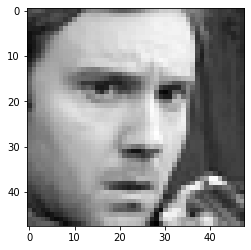

In [2]:
from matplotlib import pyplot as plt

LABELS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

print(LABELS[train_y[0]])
plt.imshow(train_x[0].reshape([48, 48]), cmap='gray')

100 epoch만 학습하여 MobileNetV2 모델 학습하기

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

# model 선언 
model = tf.keras.applications.MobileNetV2(input_shape=(48, 48, 1), weights=None, classes=7)

# model.compile
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

#model.fit
model.fit(np.stack(train_x),
          tf.keras.utils.to_categorical(train_y),
          epochs=100,
          batch_size=512,
          validation_data=(np.stack(eval_x),
                           tf.keras.utils.to_categorical(eval_y)))

1 Physical GPUs, 1 Logical GPUs
Epoch 1/100
64/64 [==============================] - 80s 1s/step - loss: 1.8296 - categorical_accuracy: 0.2421 - val_loss: 1.9287 - val_categorical_accuracy: 0.1655
Epoch 2/100
64/64 [==============================] - 6s 87ms/step - loss: 1.6851 - categorical_accuracy: 0.3259 - val_loss: 1.9208 - val_categorical_accuracy: 0.1655
Epoch 3/100
64/64 [==============================] - 6s 86ms/step - loss: 1.5729 - categorical_accuracy: 0.3838 - val_loss: 1.9233 - val_categorical_accuracy: 0.1368
Epoch 4/100
64/64 [==============================] - 6s 87ms/step - loss: 1.4875 - categorical_accuracy: 0.4253 - val_loss: 1.9212 - val_categorical_accuracy: 0.1655
Epoch 5/100
64/64 [==============================] - 6s 87ms/step - loss: 1.4022 - categorical_accuracy: 0.4621 - val_loss: 1.9248 - val_categorical_accuracy: 0.1655
Epoch 6/100
64/64 [==============================] - 6s 87ms/step - loss: 1.3353 - categorical_accuracy: 0.4932 - val_loss: 1.9246 - val_ca

Epoch 50/100
64/64 [==============================] - 6s 89ms/step - loss: 0.1347 - categorical_accuracy: 0.9536 - val_loss: 2.3686 - val_categorical_accuracy: 0.1744
Epoch 51/100
64/64 [==============================] - 6s 87ms/step - loss: 0.1839 - categorical_accuracy: 0.9365 - val_loss: 2.4249 - val_categorical_accuracy: 0.1655
Epoch 52/100
64/64 [==============================] - 6s 88ms/step - loss: 0.1169 - categorical_accuracy: 0.9602 - val_loss: 2.4179 - val_categorical_accuracy: 0.1655
Epoch 53/100
64/64 [==============================] - 6s 89ms/step - loss: 0.1114 - categorical_accuracy: 0.9622 - val_loss: 2.4630 - val_categorical_accuracy: 0.1655
Epoch 54/100
64/64 [==============================] - 6s 90ms/step - loss: 0.1755 - categorical_accuracy: 0.9405 - val_loss: 2.4810 - val_categorical_accuracy: 0.1744
Epoch 55/100
64/64 [==============================] - 6s 89ms/step - loss: 0.2291 - categorical_accuracy: 0.9200 - val_loss: 2.5486 - val_categorical_accuracy: 0.192

64/64 [==============================] - 5s 85ms/step - loss: 0.1423 - categorical_accuracy: 0.9521 - val_loss: 5.1450 - val_categorical_accuracy: 0.4224
Epoch 100/100
64/64 [==============================] - 5s 86ms/step - loss: 0.1506 - categorical_accuracy: 0.9484 - val_loss: 5.3093 - val_categorical_accuracy: 0.4126


## step 2. 학습된 모델을 TensorFlow.js 형식으로 변환하기

In [5]:
import os
model_path = os.getenv('HOME')+'/aiffel/e/tfjs_mobile/model.h5'
model.save(model_path)

`pip install tensorflowjs`로 설치하여 tf.js가 활용할 수 있는 형태로 변환하기    
터미널에서 `tensorflowjs_converter` 명령어만 실행    
```shell
$ cd ~/aiffel/tfjs_mobile
$ tensorflowjs_converter --input_format=keras model.h5 model
```

## step 3. 카메라에서 가져온 영상 전처리하기